In [1]:
# Make relative humidity netcdf JRA-55 RYF forcing file
import xarray as xr
import netCDF4 as nc
import os
import datetime
from glob import glob
from calendar import isleap
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Location of input files (air temp, humidity and SLP):
JRAin = '/g/data/ik11/inputs/JRA-55/RYF/v1-4/'

# RYF years:
RYFyrs = '1990_1991'

# Output directory:
JRAout = '/g/data/e14/rmh561/access-om2/input/JRA-55/RYF/v1-4/'

tairfile = os.path.join(JRAin,'RYF.tas.' + RYFyrs + '.nc')
qairfile = os.path.join(JRAin,'RYF.huss.' + RYFyrs + '.nc')
slpfile = os.path.join(JRAin,'RYF.psl.' + RYFyrs + '.nc')

rairfile = os.path.join(JRAout,'RYF.rhuss.' + RYFyrs + '.nc')

In [3]:
qair_ds = xr.open_dataset(qairfile,decode_coords=False)
tair_ds = xr.open_dataset(tairfile,decode_coords=False)
slp_ds = xr.open_dataset(slpfile,decode_coords=False)

In [4]:
# Copy specific humidity field and change names/meta-data:
rair_ds = qair_ds.rename({'huss':'rhuss'})
rair_ds["rhuss"].attrs["standard_name"] = "relative_humidity"
rair_ds["rhuss"].attrs["long_name"] = "Near-Surface Relative Humidity"
rair_ds["rhuss"].attrs["comment"] = "Near-surface (usually, 2 meter) relative humidity"
rair_ds["rhuss"].attrs["units"] = "percent"

In [9]:
# Constants (see CICE5/drivers/auscom/ice_constants.F90):
eref = 6.11e2 # Pascals
Lvap = 2.501e6 # Latent heat vaporization freshwater, J/kg
Tffresh = 273.15 # 0K in Celsius
rvgas = 461.5
rdgas = 287.04
rtgas = rdgas/rvgas

In [10]:
# Calculate relative humidity as a percentage:
# psl in Pa
# huss in kg/kg
# tas in K

e_sat = eref*np.exp((Lvap/rvgas)*(1./Tffresh-1./tair_ds.tas))

e = qair_ds.huss*slp_ds.psl/(rtgas+(1.-rtgas)*qair_ds.huss)

rh = e/e_sat*100.0

In [11]:
# save to file:
rair_ds.rhuss.values = rh
rair_ds.to_netcdf(rairfile)

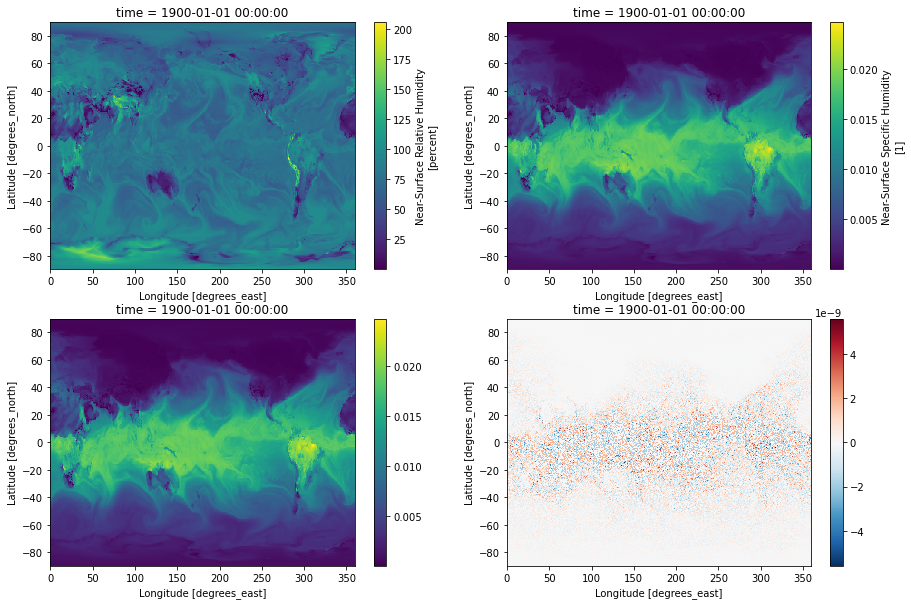

In [12]:
# Checks:
rair_ds = xr.open_dataset(rairfile,decode_coords=False)

rh = rair_ds.rhuss.isel(time=0)
tair = tair_ds.tas.isel(time=0)
slp = slp_ds.psl.isel(time=0)
qair = qair_ds.huss.isel(time=0)

# Calculated qair:
e_sat = eref*np.exp((Lvap/rvgas)*(1./Tffresh-1./tair))

q = rtgas*(rh/100.)*e_sat/(slp-(1.-rtgas)*(rh/100.)*e_sat)

fig,axes = plt.subplots(figsize=(15,10),nrows=2,ncols=2)
rh.plot(ax=axes[0][0])
qair.plot(ax=axes[0][1])
q.plot(ax=axes[1][0])
(qair-q).plot(ax=axes[1][1])

# Quick comparison of results:

-0.001PW


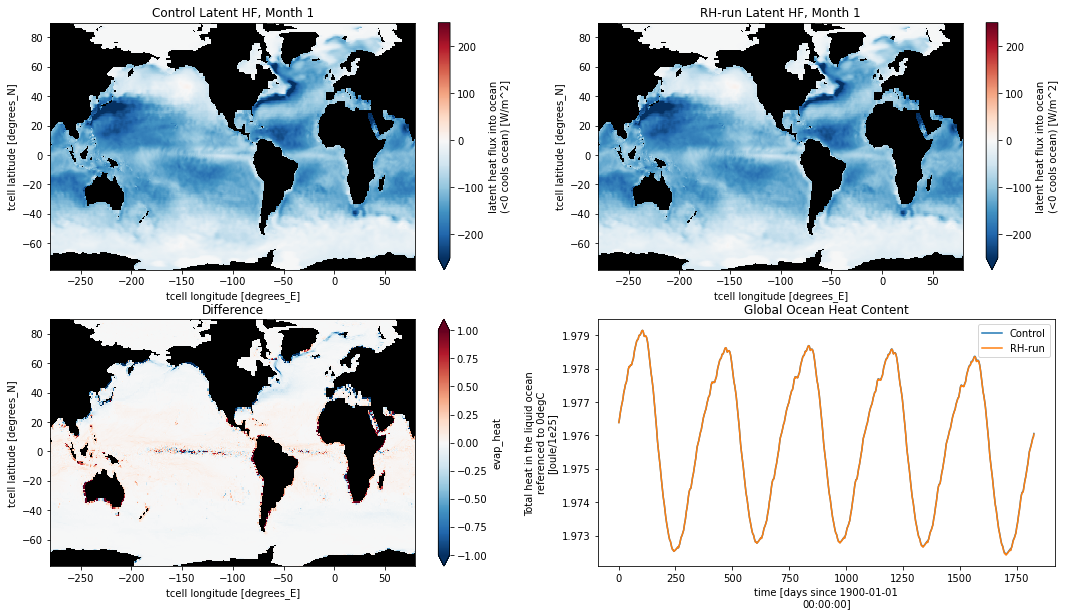

In [3]:
cont = xr.open_mfdataset('/scratch/e14/rmh561/access-om2/archive/1deg_jra55_ryf/output000/ocean/*evap_heat*1.nc',decode_times=False)
pert = xr.open_mfdataset('/scratch/e14/rmh561/access-om2/archive/1deg_jra55_ryf_RHtest/output000/ocean/*evap_heat*1.nc',decode_times=False)

fig,axes = plt.subplots(nrows=2,ncols=2,figsize=(18,10))
cont.evap_heat.isel(time=0).plot(ax=axes[0][0],vmin=-250.,vmax=250.,cmap='RdBu_r')
axes[0][0].set_title('Control Latent HF, Month 1')
pert.evap_heat.isel(time=0).plot(ax=axes[0][1],vmin=-250.,vmax=250.,cmap='RdBu_r')
axes[0][1].set_title('RH-run Latent HF, Month 1')

(pert.evap_heat.isel(time=0)-cont.evap_heat.isel(time=0)).plot(ax=axes[1][0],vmin=-1.,vmax=1.,cmap='RdBu_r')
axes[1][0].set_title('Difference')

for ax in axes.reshape(-1)[:-1]:
    ax.set_facecolor('k')

contSC = xr.open_mfdataset('/scratch/e14/rmh561/access-om2/archive/1deg_jra55_ryf/output000/ocean/*scalar*1.nc',decode_times=False)
pertSC = xr.open_mfdataset('/scratch/e14/rmh561/access-om2/archive/1deg_jra55_ryf_RHtest/output000/ocean/*scalar*1.nc',decode_times=False)

contSC.total_ocean_heat.plot(label='Control',ax=axes[1][1])
pertSC.total_ocean_heat.plot(label='RH-run',ax=axes[1][1])
axes[1][1].set_title('Global Ocean Heat Content')
axes[1][1].legend()
dPW = (pertSC.total_ocean_heat.isel(time=-1).values-contSC.total_ocean_heat.isel(time=-1).values)*1.e25/(86400.*365*5)/1.e15
print('%3.3fPW' % dPW)

plt.savefig('RHrun_test_simpleformula2.png',dpi=300,bbox_inches='tight')